This is a script to create and register a naive non-ML baseline forecasting model.

**The model**: For a given input (with a timestamp index feature), it predicts the average electricity demand value for that month and hour of day.

This model is then registered to the MLFlow model registry.

# Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import mlflow
import getpass

In [2]:
import os
print(os.getcwd())

/app/notebooks


In [3]:
# Auto reload core modules so I don't need to restart kernel when I change
# the code in those modules
%load_ext autoreload
%autoreload 2

In [4]:
#sys.path.append('../')
from core.data import (
    request_EIA_data, get_dvc_remote_repo_url, get_dvc_dataset_as_df,
)
from core.consts import EIA_TEST_SET_HOURS
from flows.train_model_flow import clean_data, features, mlflow_emit_tags_and_params
from flows.compare_models_flow import fetch_eval_dataset
from core.types import DVCDatasetInfo, MLFlowModelSpecifier

/usr/local/lib/python3.10/site-packages/pydantic/_internal/_fields.py:161: UserWarning: Field "model_specifiers" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


# Get training data

In [5]:
git_PAT = getpass.getpass(prompt='Enter DVC git repo PAT')

Enter DVC git repo PAT ········


In [6]:
git_repo_url = get_dvc_remote_repo_url(git_PAT)
path = 'data/eia_d_df_2019-01-01_00_2024-08-14_00.parquet'
rev = '4e23cce2fba3111922bda0676d7edac39a95e3f6'
dvc_dataset_info = DVCDatasetInfo(repo=git_repo_url, path=path, rev=rev)
df = get_dvc_dataset_as_df(dvc_dataset_info)

In [7]:
df

,respondent,D,DF
utc_ts,,,
2019-01-01 00:00:00+00:00,PJM,94016.0,100991.0
2019-01-01 01:00:00+00:00,PJM,90385.0,99187.0
2019-01-01 02:00:00+00:00,PJM,86724.0,97091.0
2019-01-01 03:00:00+00:00,PJM,82978.0,93374.0
2019-01-01 04:00:00+00:00,PJM,79536.0,87684.0
...,...,...,...
2024-08-13 20:00:00+00:00,PJM,117599.0,117610.0
2024-08-13 21:00:00+00:00,PJM,120167.0,118483.0
2024-08-13 22:00:00+00:00,PJM,121754.0,117000.0


In [8]:
df = await clean_data(df)
df = await features(df)

15:38:56.767 | INFO    | prefect.engine - Created task run 'clean_data-e6a8145c' for task 'clean_data'

Input data skew: 157.69167688006226
Output data skew: 0.8495765960582895
Null demand values: 117


15:38:58.157 | INFO    | Task run 'clean_data-e6a8145c' - Finished in state Completed()

15:38:58.407 | INFO    | prefect.engine - Created task run 'features-dfc7b070' for task 'features'

                          respondent         D  hour  month  year  quarter  \
utc_ts                                                                       
2019-01-01 00:00:00+00:00        PJM   94016.0     0      1  2019        1   
2019-01-01 01:00:00+00:00        PJM   90385.0     1      1  2019        1   
2019-01-01 02:00:00+00:00        PJM   86724.0     2      1  2019        1   
2019-01-01 03:00:00+00:00        PJM   82978.0     3      1  2019        1   
2019-01-01 04:00:00+00:00        PJM   79536.0     4      1  2019        1   
...                              ...       ...   ...    ...   ...      ...   
2024-08-13 20:00:00+00:00        PJM  117599.0    20      8  2024        3   
2024-08-13 21:00:00+00:00        PJM  120167.0    21      8  2024        3   
2024-08-13 22:00:00+00:00        PJM  121754.0    22      8  2024        3   
2024-08-13 23:00:00+00:00        PJM  120845.0    23      8  2024        3   
2024-08-14 00:00:00+00:00        PJM  116885.0     0      8  202

15:38:58.803 | INFO    | Task run 'features-dfc7b070' - Finished in state Completed()

In [9]:
df

,respondent,D,hour,month,year,quarter,dayofweek,dayofmonth,dayofyear
utc_ts,,,,,,,,,
2019-01-01 00:00:00+00:00,PJM,94016.0,0,1,2019,1,1,1,1
2019-01-01 01:00:00+00:00,PJM,90385.0,1,1,2019,1,1,1,1
2019-01-01 02:00:00+00:00,PJM,86724.0,2,1,2019,1,1,1,1
2019-01-01 03:00:00+00:00,PJM,82978.0,3,1,2019,1,1,1,1
2019-01-01 04:00:00+00:00,PJM,79536.0,4,1,2019,1,1,1,1
...,...,...,...,...,...,...,...,...,...
2024-08-13 20:00:00+00:00,PJM,117599.0,20,8,2024,3,1,13,226
2024-08-13 21:00:00+00:00,PJM,120167.0,21,8,2024,3,1,13,226
2024-08-13 22:00:00+00:00,PJM,121754.0,22,8,2024,3,1,13,226


Chop off the last `EIA_TEST_SET_HOURS` hours, so the training set leaves enough of a test set window for adhoc model evaluation.

In [10]:
df = df[:-EIA_TEST_SET_HOURS]

# Calculate average demand by hour

In [11]:
demand_by_hour_month = df.groupby(['hour','month'])['D'].agg(pd.Series.mean)
demand_by_hour_month

hour  month
0     1        105112.139785
      2        100940.605882
      3         89774.677596
      4         82412.405556
      5         88564.392473
                   ...      
23    8        121492.884141
      9        102162.340000
      10        86051.445161
      11        91628.154362
      12        99661.335484
Name: D, Length: 288, dtype: float64

In [12]:
type(demand_by_hour_month)
demand_by_hour_month[(23,8)]

121492.88414139464

# Define Baseline Model

Define my simple model (lookup table) function so that it implements the sci-kit learn [Predictor interface](https://scikit-learn.org/stable/developers/develop.html#different-objects).

In [13]:
class BaselineModel(mlflow.pyfunc.PythonModel):
    def __init__(self, demand_by_hour_month):
        self.dbhm = demand_by_hour_month
    
    def predict(self, context, model_input_df):
        # Assuming model_input contains a column 'hour' with the hour of the data point
        def demand_for_row(row):
            key_tuple = (row['hour'], row['month']) 
            return self.dbhm[key_tuple]
        return model_input_df.apply(demand_for_row, axis=1)

In [14]:
baseline_model = BaselineModel(demand_by_hour_month)

# Visualize model predictions

In [15]:
eval_df = await fetch_eval_dataset()
eval_df

15:38:59.314 | INFO    | prefect.engine - Created task run 'fetch_eval_dataset-226e98b3' for task 'fetch_eval_dataset'

15:38:59.735 | INFO    | prefect.engine - Created task run 'get_eia_data_as_df-ddef28ff' for task 'get_eia_data_as_df'

Fetching API page. offset:0. length:5000


15:39:02.358 | INFO    | Task run 'get_eia_data_as_df-ddef28ff' - Finished in state Completed()

15:39:02.508 | INFO    | prefect.engine - Created task run 'transform-bf022df5' for task 'transform'

Transforming timeseries.
Dataframe info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 337 entries, 2024-08-03 00:00:00+00:00 to 2024-08-17 00:00:00+00:00
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   respondent  337 non-null    object
 1   D           337 non-null    int64 
 2   DF          337 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 10.5+ KB


Dataframe dtypes:
respondent    object
D              int64
DF             int64
dtype: object

Dataframe head:
                          respondent       D      DF
utc_ts                                              
2024-08-03 00:00:00+00:00        PJM  131147  126124
2024-08-03 01:00:00+00:00        PJM  125796  121086
2024-08-03 02:00:00+00:00        PJM  120493  113929
2024-08-03 03:00:00+00:00        PJM  113789  106288
2024-08-03 04:00:00+00:00        PJM  108430   99896



15:39:02.889 | INFO    | Task run 'transform-bf022df5' - Finished in state Completed()

15:39:03.007 | INFO    | prefect.engine - Created task run 'clean_data-18991af4' for task 'clean_data'

Input data skew: 0.26404313121336154
Output data skew: 0.26404313121336154
Null demand values: 0


15:39:03.400 | INFO    | Task run 'clean_data-18991af4' - Finished in state Completed()

15:39:03.509 | INFO    | prefect.engine - Created task run 'features-43289581' for task 'features'

                          respondent       D  hour  month  year  quarter  \
utc_ts                                                                     
2024-08-03 00:00:00+00:00        PJM  131147     0      8  2024        3   
2024-08-03 01:00:00+00:00        PJM  125796     1      8  2024        3   
2024-08-03 02:00:00+00:00        PJM  120493     2      8  2024        3   
2024-08-03 03:00:00+00:00        PJM  113789     3      8  2024        3   
2024-08-03 04:00:00+00:00        PJM  108430     4      8  2024        3   
...                              ...     ...   ...    ...   ...      ...   
2024-08-16 20:00:00+00:00        PJM  126636    20      8  2024        3   
2024-08-16 21:00:00+00:00        PJM  128643    21      8  2024        3   
2024-08-16 22:00:00+00:00        PJM  128935    22      8  2024        3   
2024-08-16 23:00:00+00:00        PJM  126208    23      8  2024        3   
2024-08-17 00:00:00+00:00        PJM  121761     0      8  2024        3   

           

15:39:03.822 | INFO    | Task run 'features-43289581' - Finished in state Completed()

Eval data df:
                                D  hour  month  year  quarter  dayofweek  \
utc_ts                                                                     
2024-08-03 00:00:00+00:00  131147     0      8  2024        3          5   
2024-08-03 01:00:00+00:00  125796     1      8  2024        3          5   
2024-08-03 02:00:00+00:00  120493     2      8  2024        3          5   
2024-08-03 03:00:00+00:00  113789     3      8  2024        3          5   
2024-08-03 04:00:00+00:00  108430     4      8  2024        3          5   
...                           ...   ...    ...   ...      ...        ...   
2024-08-16 20:00:00+00:00  126636    20      8  2024        3          4   
2024-08-16 21:00:00+00:00  128643    21      8  2024        3          4   
2024-08-16 22:00:00+00:00  128935    22      8  2024        3          4   
2024-08-16 23:00:00+00:00  126208    23      8  2024        3          4   
2024-08-17 00:00:00+00:00  121761     0      8  2024        3          5  

15:39:04.018 | INFO    | Task run 'fetch_eval_dataset-226e98b3' - Finished in state Completed()

,D,hour,month,year,quarter,dayofweek,dayofmonth,dayofyear
utc_ts,,,,,,,,
2024-08-03 00:00:00+00:00,131147,0,8,2024,3,5,3,216
2024-08-03 01:00:00+00:00,125796,1,8,2024,3,5,3,216
2024-08-03 02:00:00+00:00,120493,2,8,2024,3,5,3,216
2024-08-03 03:00:00+00:00,113789,3,8,2024,3,5,3,216
2024-08-03 04:00:00+00:00,108430,4,8,2024,3,5,3,216
...,...,...,...,...,...,...,...,...
2024-08-16 20:00:00+00:00,126636,20,8,2024,3,4,16,229
2024-08-16 21:00:00+00:00,128643,21,8,2024,3,4,16,229
2024-08-16 22:00:00+00:00,128935,22,8,2024,3,4,16,229


In [16]:
pred = baseline_model.predict(None, eval_df)

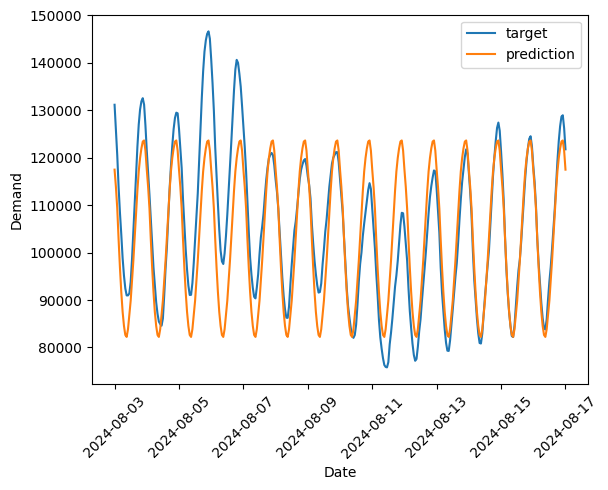

In [17]:
plt.plot(eval_df.index, eval_df.D, label='target')
plt.plot(eval_df.index, pred, label='prediction')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Demand')
plt.legend()
plt.show()

# Log the model to mlflow

In [18]:
mlflow.set_tracking_uri(uri=os.getenv('MLFLOW_ENDPOINT_URI'))
with mlflow.start_run():
    mlflow_emit_tags_and_params(df, dvc_dataset_info)
    mlflow.pyfunc.log_model(artifact_path="baseline_model", python_model=baseline_model)

2024/08/19 15:39:05 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/19 15:39:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run flawless-snipe-155 at: http://mlflow:5001/#/experiments/0/runs/678c311f49ec4361ba5716834c135c3e.
2024/08/19 15:39:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow:5001/#/experiments/0.


# Visualize and Compare performance metrics over time

In [25]:
mlflow.set_tracking_uri(uri=os.getenv('MLFLOW_ENDPOINT_URI'))
runs = mlflow.search_runs(experiment_names=['xgb.df.compare_models'])
runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.mean_absolute_error,metrics.example_count,metrics.mean_on_target,metrics.max_error,...,metrics.r2_score,metrics.mean_squared_error,params.model_name,params.model_version,tags.mlflow.runName,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.datasets,tags.mlflow.source.type,tags.prefect_flow_run
0,8896212b6f604363a6b4d1cf821b9f3d,128223311134607822,FINISHED,mlflow-artifacts:/128223311134607822/8896212b6...,2024-08-19 15:35:32.356000+00:00,2024-08-19 15:35:32.407000+00:00,6601.521280,337.0,105227.267062,23596.115859,...,0.699602,7.696506e+07,baseline,4,baseline-v4_eval,root,/usr/local/lib/python3.10/site-packages/prefec...,"[{""name"":""2ffe1882b827f52ce3dea481d93e4584"",""h...",LOCAL,alpha2-firienholt-expanse
1,e019e6d734da4a749a6159f1f825539a,128223311134607822,FINISHED,mlflow-artifacts:/128223311134607822/e019e6d73...,2024-08-19 15:35:31.611000+00:00,2024-08-19 15:35:31.690000+00:00,7069.766181,337.0,105227.267062,19836.054688,...,0.697697,7.745326e+07,xgboost-df,3,xgboost-df-v3_eval,root,/usr/local/lib/python3.10/site-packages/prefec...,"[{""name"":""2ffe1882b827f52ce3dea481d93e4584"",""h...",LOCAL,alpha2-firienholt-expanse
2,e85c2d79434147e7bb7e0e52b806700f,128223311134607822,FINISHED,mlflow-artifacts:/128223311134607822/e85c2d794...,2024-08-19 14:39:40.572000+00:00,2024-08-19 14:39:40.628000+00:00,6601.521280,337.0,105227.267062,23596.115859,...,0.699602,7.696506e+07,baseline,4,baseline-v4_eval,root,/usr/local/lib/python3.10/site-packages/prefec...,"[{""name"":""2ffe1882b827f52ce3dea481d93e4584"",""h...",LOCAL,lambda26-delios
3,4e452bf9e935453a8edae5bb81789f7d,128223311134607822,FINISHED,mlflow-artifacts:/128223311134607822/4e452bf9e...,2024-08-19 14:39:39.863000+00:00,2024-08-19 14:39:39.931000+00:00,7069.766181,337.0,105227.267062,19836.054688,...,0.697697,7.745326e+07,xgboost-df,2,xgboost-df-v2_eval,root,/usr/local/lib/python3.10/site-packages/prefec...,"[{""name"":""2ffe1882b827f52ce3dea481d93e4584"",""h...",LOCAL,lambda26-delios
4,41841436224c4e529030ece5177a7b3c,128223311134607822,FINISHED,mlflow-artifacts:/128223311134607822/418414362...,2024-08-19 14:35:32.021000+00:00,2024-08-19 14:35:32.070000+00:00,6601.521280,337.0,105227.267062,23596.115859,...,0.699602,7.696506e+07,baseline,4,baseline-v4_eval,root,/usr/local/lib/python3.10/site-packages/prefec...,"[{""name"":""2ffe1882b827f52ce3dea481d93e4584"",""h...",LOCAL,chi3-vandros
5,d5bcfdba40c740b0ae9853209fa2d53c,128223311134607822,FINISHED,mlflow-artifacts:/128223311134607822/d5bcfdba4...,2024-08-19 14:35:31.530000+00:00,2024-08-19 14:35:31.592000+00:00,7069.766181,337.0,105227.267062,19836.054688,...,0.697697,7.745326e+07,xgboost-df,2,xgboost-df-v2_eval,root,/usr/local/lib/python3.10/site-packages/prefec...,"[{""name"":""2ffe1882b827f52ce3dea481d93e4584"",""h...",LOCAL,chi3-vandros
6,f96f1ec1442e464dbdc7915b099dae22,128223311134607822,FINISHED,mlflow-artifacts:/128223311134607822/f96f1ec14...,2024-08-18 17:03:05.028000+00:00,2024-08-18 17:03:05.084000+00:00,7853.734930,337.0,106479.480712,26939.242320,...,0.621726,1.056261e+08,baseline,4,baseline-v4_eval,root,/usr/local/lib/python3.10/site-packages/prefec...,"[{""name"":""cc3c05e214957603dd38cf04569736c4"",""h...",LOCAL,xi-dziban
7,fdb04eddb12d479aa740e93471800032,128223311134607822,FINISHED,mlflow-artifacts:/128223311134607822/fdb04eddb...,2024-08-18 17:03:04.103000+00:00,2024-08-18 17:03:04.340000+00:00,8358.497844,337.0,106479.480712,29617.710938,...,0.592005,1.139252e+08,xgboost-df,2,xgboost-df-v2_eval,root,/usr/local/lib/python3.10/site-packages/prefec...,"[{""name"":""cc3c05e214957603dd38cf04569736c4"",""h...",LOCAL,xi-dziban
8,a87fe7a8663d42d6b774ef9bccfb3d6f,128223311134607822,FINISHED,mlflow-artifacts:/128223311134607822/a87fe7a86...,2024-08-17 03:49:13.421000+00:00,2024-08-17 03:49:13.467000+00:00,9153.565547,337.0,107823.946588,26939.242320,...,0.563640,1.332876e+08,baseline,4,baseline-v4_eval,root,/usr/local/lib/python3.10/site-pack

In [26]:
# Cast some types
runs['start_time'] = pd.to_datetime(runs['start_time'], utc=True)
runs['params.model_version'] = pd.to_numeric(runs['params.model_version'])
runs['metrics.root_mean_squared_error'] = pd.to_numeric(runs['metrics.root_mean_squared_error'])

In [27]:
runs.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.mean_absolute_error,metrics.example_count,metrics.mean_on_target,metrics.max_error,...,metrics.r2_score,metrics.mean_squared_error,params.model_name,params.model_version,tags.mlflow.runName,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.datasets,tags.mlflow.source.type,tags.prefect_flow_run
0,8896212b6f604363a6b4d1cf821b9f3d,128223311134607822,FINISHED,mlflow-artifacts:/128223311134607822/8896212b6...,2024-08-19 15:35:32.356000+00:00,2024-08-19 15:35:32.407000+00:00,6601.521280,337.0,105227.267062,23596.115859,...,0.699602,7.696506e+07,baseline,4,baseline-v4_eval,root,/usr/local/lib/python3.10/site-packages/prefec...,"[{""name"":""2ffe1882b827f52ce3dea481d93e4584"",""h...",LOCAL,alpha2-firienholt-expanse
1,e019e6d734da4a749a6159f1f825539a,128223311134607822,FINISHED,mlflow-artifacts:/128223311134607822/e019e6d73...,2024-08-19 15:35:31.611000+00:00,2024-08-19 15:35:31.690000+00:00,7069.766181,337.0,105227.267062,19836.054688,...,0.697697,7.745326e+07,xgboost-df,3,xgboost-df-v3_eval,root,/usr/local/lib/python3.10/site-packages/prefec...,"[{""name"":""2ffe1882b827f52ce3dea481d93e4584"",""h...",LOCAL,alpha2-firienholt-expanse
2,e85c2d79434147e7bb7e0e52b806700f,128223311134607822,FINISHED,mlflow-artifacts:/128223311134607822/e85c2d794...,2024-08-19 14:39:40.572000+00:00,2024-08-19 14:39:40.628000+00:00,6601.521280,337.0,105227.267062,23596.115859,...,0.699602,7.696506e+07,baseline,4,baseline-v4_eval,root,/usr/local/lib/python3.10/site-packages/prefec...,"[{""name"":""2ffe1882b827f52ce3dea481d93e4584"",""h...",LOCAL,lambda26-delios
3,4e452bf9e935453a8edae5bb81789f7d,128223311134607822,FINISHED,mlflow-artifacts:/128223311134607822/4e452bf9e...,2024-08-19 14:39:39.863000+00:00,2024-08-19 14:39:39.931000+00:00,7069.766181,337.0,105227.267062,19836.054688,...,0.697697,7.745326e+07,xgboost-df,2,xgboost-df-v2_eval,root,/usr/local/lib/python3.10/site-packages/prefec...,"[{""name"":""2ffe1882b827f52ce3dea481d93e4584"",""h...",LOCAL,lambda26-delios
4,41841436224c4e529030ece5177a7b3c,128223311134607822,FINISHED,mlflow-artifacts:/128223311134607822/418414362...,2024-08-19 14:35:32.021000+00:00,2024-08-19 14:35:32.070000+00:00,6601.521280,337.0,105227.267062,23596.115859,...,0.699602,7.696506e+07,baseline,4,baseline-v4_eval,root,/usr/local/lib/python3.10/site-packages/prefec...,"[{""name"":""2ffe1882b827f52ce3dea481d93e4584"",""h...",LOCAL,chi3-vandros


In [28]:
runs.columns

Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.mean_absolute_error', 'metrics.example_count',
       'metrics.mean_on_target', 'metrics.max_error', 'metrics.sum_on_target',
       'metrics.root_mean_squared_error',
       'metrics.mean_absolute_percentage_error', 'metrics.r2_score',
       'metrics.mean_squared_error', 'params.model_name',
       'params.model_version', 'tags.mlflow.runName', 'tags.mlflow.user',
       'tags.mlflow.source.name', 'tags.mlflow.datasets',
       'tags.mlflow.source.type', 'tags.prefect_flow_run'],
      dtype='object')

In [29]:
def filter_runs(runs_df, model_name, model_version):
    mn_mask = runs_df['params.model_name'] == model_name
    mv_mask = runs_df['params.model_version'] == model_version
    return runs_df[mn_mask & mv_mask]

models = [MLFlowModelSpecifier(name='baseline', version=4), MLFlowModelSpecifier(name='xgboost-df', version=2)]

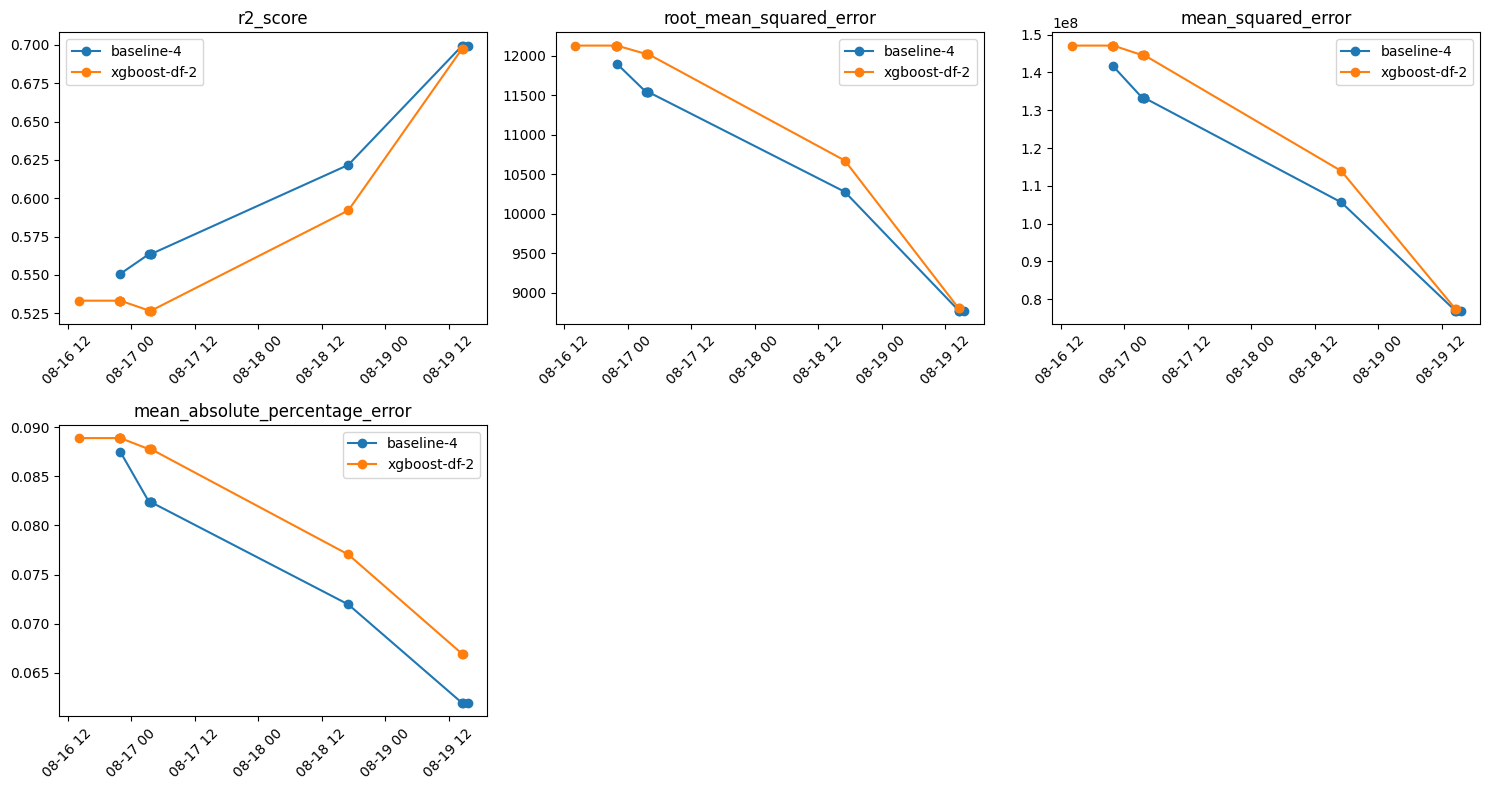

In [30]:
metrics = ['r2_score', 'root_mean_squared_error', 'mean_squared_error', 'mean_absolute_percentage_error']
num_cols = 3
num_rows = (len(metrics) // num_cols) + 1

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 8))
axs = axs.flat
for m in models:
    model_runs_df = filter_runs(runs, m.name, m.version)
    for i, metric in enumerate(metrics):
        #print(f'model:{m.name}. metric:{metric}. data:{model_runs_df[f"metrics.{metric}"]}')
        axs[i].set_title(metric)
        axs[i].plot(model_runs_df.start_time, model_runs_df[f'metrics.{metric}'], 
                 marker='o', label=f'{m.name}-{m.version}')
        axs[i].legend()
        axs[i].tick_params(axis='x', rotation=45)
        
# Remove axes for any extra subplots beyond the number of metrics
for i in range(len(metrics), len(axs)):
    fig.delaxes(axs[i])
    
plt.tight_layout()
plt.show()

In [34]:
from flows.compare_models_flow import generate_performance_plot

await generate_performance_plot(['xgboost-df', 'baseline'])

/usr/local/lib/python3.10/site-packages/pydantic/_internal/_fields.py:161: UserWarning: Field "model_specifiers" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


16:00:17.030 | INFO    | prefect.engine - Created task run 'generate_performance_plot-1f91cccd' for task 'generate_performance_plot'

Summary of runs for experiment xgb.df.compare_models:
                             run_id       experiment_id    status  \
0  46ed538227b9492c893ee36605fa10a2  128223311134607822  FINISHED   
1  8f618b4edb2548698f27741215fa5e3f  128223311134607822  FINISHED   
2  3b8b6d7087e04c6fa45c694dbcb7eed5  128223311134607822  FINISHED   
3  b7ce3c3340a343fe8cdb5680353a1982  128223311134607822  FINISHED   

                                        artifact_uri  \
0  mlflow-artifacts:/128223311134607822/46ed53822...   
1  mlflow-artifacts:/128223311134607822/8f618b4ed...   
2  mlflow-artifacts:/128223311134607822/3b8b6d708...   
3  mlflow-artifacts:/128223311134607822/b7ce3c334...   

                        start_time                         end_time  \
0 2024-08-19 15:58:47.743000+00:00 2024-08-19 15:58:47.805000+00:00   
1 2024-08-19 15:58:47.108000+00:00 2024-08-19 15:58:47.186000+00:00   
2 2024-08-19 15:53:49.419000+00:00 2024-08-19 15:53:49.480000+00:00   
3 2024-08-19 15:53:48.746000+00:00 

2024/08/19 16:00:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run agreeable-shrike-44 at: http://mlflow:5001/#/experiments/487572773557188084/runs/ba1e562ac6874e34995eb814c7ac3932.
2024/08/19 16:00:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow:5001/#/experiments/487572773557188084.


16:00:18.096 | INFO    | Task run 'generate_performance_plot-1f91cccd' - Finished in state Completed()

In [36]:
from mlflow import MlflowClient
client = MlflowClient()
experiment_name = "xgb.df.compare_models"
experiment = client.get_experiment_by_name(experiment_name)
runs = client.search_runs(experiment_ids=[experiment.experiment_id])

In [38]:
runs[0].info

<RunInfo: artifact_uri='mlflow-artifacts:/128223311134607822/8fe8f29f27ff497d844aa3777845c764/artifacts', end_time=1724090310193, experiment_id='128223311134607822', lifecycle_stage='active', run_id='8fe8f29f27ff497d844aa3777845c764', run_name='baseline-v1_eval', run_uuid='8fe8f29f27ff497d844aa3777845c764', start_time=1724090310140, status='FINISHED', user_id='root'>